An exacerbation's start can be spotted by the pattern [False, True] in Is Exacerbated. Similarly, it's [True, False] for an exacerbation's end.

Functions exported to `ex_labels_data.py`

In [1]:
import ex_labels_data
import numpy as np
import pandas as pd
import O2_FEV1_df
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
O2_FEV1 = O2_FEV1_df.create()
ex_labels = ex_labels_data.load()
O2_FEV1_with_ex_labels = ex_labels_data.inner_merge_with(
    O2_FEV1, ex_labels, exclude_no_ex=True
)
O2_FEV1_with_ex_labels.head()


** Loading measurements data **

* Dropping unnecessary columns from measurements data *
Columns filtered ['User ID', 'UserName', 'Recording Type', 'Date/Time recorded', 'FEV 1', 'Weight in Kg', 'O2 Saturation', 'Pulse (BPM)', 'Rating', 'Temp (deg C)']
Dropping columns {'Calories', 'Sputum sample taken?', 'Activity - Points', 'Predicted FEV', 'FEV 10', 'Activity - Steps', 'FEV 1 %'}

* Renaming columns *
Renamed columns {'Date/Time recorded': 'Date recorded', 'FEV 1': 'FEV1', 'Weight in Kg': 'Weight (kg)'}


/Users/tristan.trebaol/Desktop/PhD/Code/phd/src/data/measurements_data.py:101: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datadir + "mydata.csv")



* Applying data sanity checks *

FEV1
Dropping 1 entries with FEV1 = 3.45 for user Kings004

Weight (kg)
Dropping 2 entries with Weight (kg) = 6.0 for user Papworth033
Dropping 1 entries with Weight (kg) = 0.55 for user Kings013
Dropping 1 entries with Weight (kg) = 8.262500000000001 for user Papworth017
Dropping 1 entries with Weight (kg) = 1056.0 for user leeds01730
Dropping 1 entries with Weight (kg) = 20.0 for user Papworth019
Warning - ID PapworthSummer has Weight (28.9375) outside 30-122 kg range
Warning - ID PapworthSummer has Weight (29.200000000000003) outside 30-122 kg range
Warning - ID EmemTest has Weight (14.9625) outside 30-122 kg range
Warning - ID FPH0011 has Weight (7.8) outside 30-122 kg range

Pulse (BPM)
Dropping 14 entries with Pulse (BPM) == 511)
       Pulse (BPM)      UserName
60638        511.0   Papworth002
60989        511.0   Papworth001
61026        511.0    leeds01050
61374        511.0    leeds01320
63126        511.0      Kings005
63525        511.0    

/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/tristan.trebaol/Desktop/PhD/Code/phd/src/data/patient_data.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Height.loc[df.ID == "60"] = tmp * 100
/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():



* Dropping unnecessary columns from patient data *
Columns filtered: ['ID', 'Study Date', 'DOB', 'Age', 'Sex', 'Height', 'Weight', 'Predicted FEV1', 'FEV1 Set As']
Columns dropped: {'Unable Sputum Samples', 'Hospital', 'GP Letter Sent', 'Pulmonary Exacerbation', 'Study Email', 'Study Number', 'Freezer Required', 'Genetic Testing', 'Sputum Samples', 'Date Last PE Start', 'Unable Informed Consent', 'Telemetric Measures', 'Inconvenience Payment', 'Informed Consent', 'Age 18 Years', 'Transplant Recipients', 'Comments', 'Date Consent Obtained', 'CFQR Quest Comp', 'Less Exacerbation', 'Remote Monitoring App User ID', 'Date Last PE Stop'}

* Correcting patient data *
ID 60: Corrected height 60 from 1.63 to 163.0
ID 66: Corrected height for ID 66 from 1.62 to 162.0
Replace Age by calculate age
Drop FEV1 Set As and Predicted FEV1
Compute Calculated Predicted FEV1

* Applying data sanity checks *
Loaded patient data with 147 entries (147 initially)

** Loading antibiotics data **

* Dropping un

,ID,Date recorded,O2 Saturation,FEV1,Study Date,DOB,Age,Sex,Height,Weight,Predicted FEV1,FEV1 % Predicted,Is Exacerbated
0,23,2015-08-12,95.0,1.49,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,66.921177,False
2,23,2015-08-14,95.0,1.29,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,57.938468,False
3,23,2015-08-21,94.0,1.35,2015-08-03,1960-07-05,55,Female,157.0,63.4,2.2265,60.633281,False
4,137,2015-08-26,95.0,1.28,2015-08-25,1976-05-24,39,Female,172.0,61.0,3.2190,39.763902,False
7,24,2015-08-28,98.0,2.55,2015-08-06,1990-11-25,25,Female,166.0,74.2,3.3320,76.530612,False


In [3]:
test_df = ex_labels[ex_labels.ID == "241"].copy()
test_df = ex_labels_data.mark_ex_transition_period(test_df)
test_df.iloc[30:41]

** Marking transition period around exacerbation start **
Initially:
False    37
True     10
Name: Is Exacerbated, dtype: int64
Finally:
0.0    35
1.0     7
0.5     5
Name: Exacerbation State, dtype: int64


,index,PatientNbr,Study,ID,CalcDate,CalcDatedn,ScenType,Scenario,BaseExample,Measure,Frequency,Percentage,MSExample,Is Exacerbated,Date recorded,Exacerbation State
30,14434,104,SC,241,08-Apr-2016,31,0,Actual,0,NaN,0,0,0,False,2016-04-08,0.0
31,14435,104,SC,241,09-Apr-2016,32,0,Actual,0,NaN,0,0,0,False,2016-04-09,0.0
32,14436,104,SC,241,10-Apr-2016,33,0,Actual,0,NaN,0,0,0,False,2016-04-10,0.0
33,14437,104,SC,241,11-Apr-2016,34,0,Actual,0,NaN,0,0,0,False,2016-04-11,0.0
34,14438,104,SC,241,12-Apr-2016,35,0,Actual,0,NaN,0,0,0,False,2016-04-12,0.0
35,14439,104,SC,241,13-Apr-2016,36,0,Actual,0,NaN,0,0,0,False,2016-04-13,0.5
36,14440,104,SC,241,14-Apr-2016,37,0,Actual,0,NaN,0,0,0,False,2016-04-14,0.5
37,14441,104,SC,241,15-Apr-2016,38,0,Actual,0,NaN,0,0,0,True,2016-04-15,0.5
38,14442,104,SC,241,16-Apr-2016,39,0,Actual,0,NaN,0,0,0,True,2016-04-16,0.5
39,14443,104,SC,241,17-Apr-2016,40,0,Actual,0,NaN,0,0,0,True,2016-04-17,0.5


# Visualization of the transition period
Issues
- [Solved] not sorted by dates
- [Solved] the transition period should be marked by number of days around the start date, not by a certain amount of indices to the right and to the left

** Marking transition period around exacerbation start **
Initially:
False    3269
True      723
Name: Is Exacerbated, dtype: int64
Finally:
0.0    3194
1.0     585
0.5     213
Name: Exacerbation State, dtype: int64


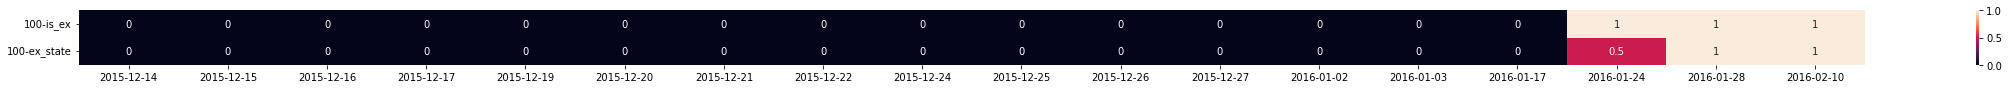

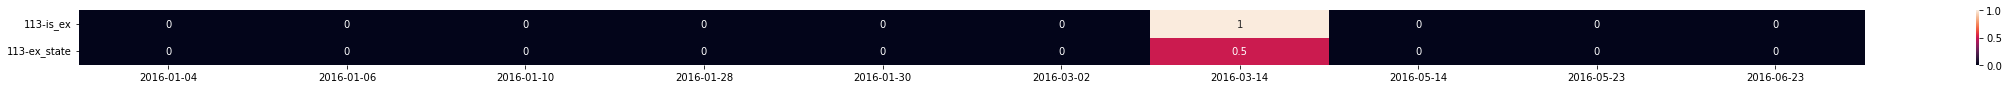

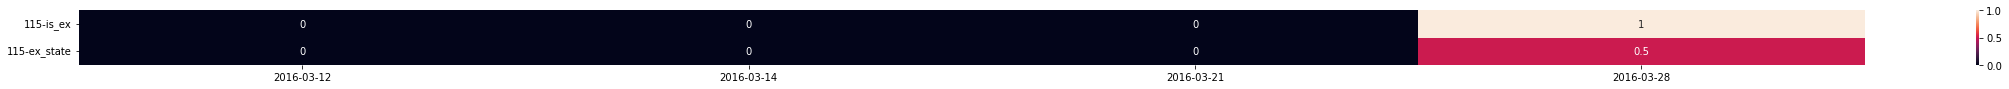

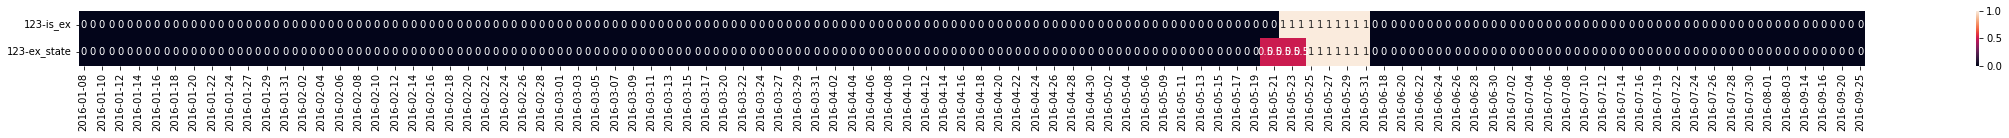

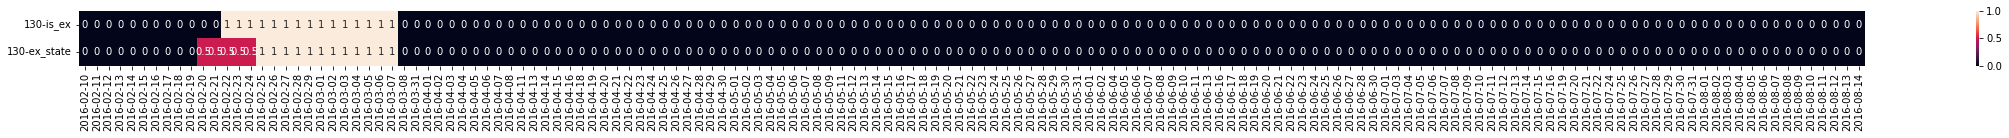

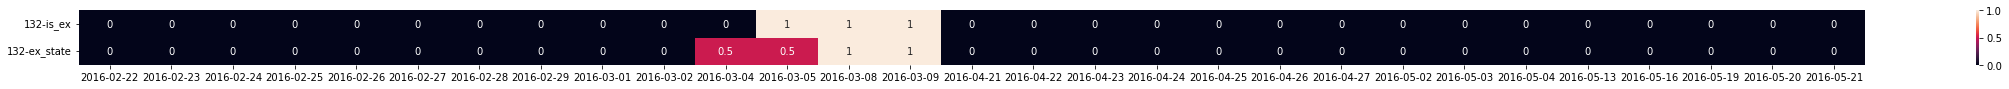

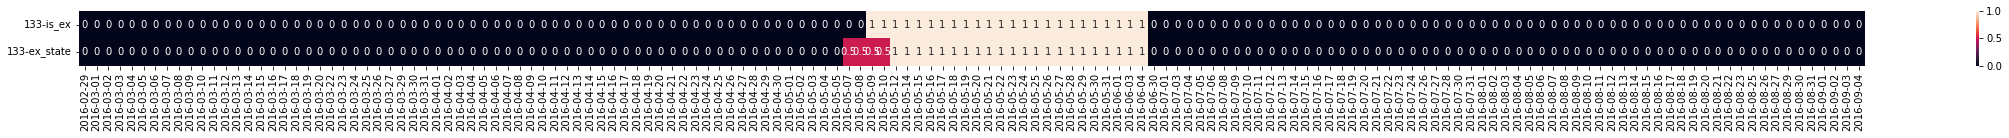

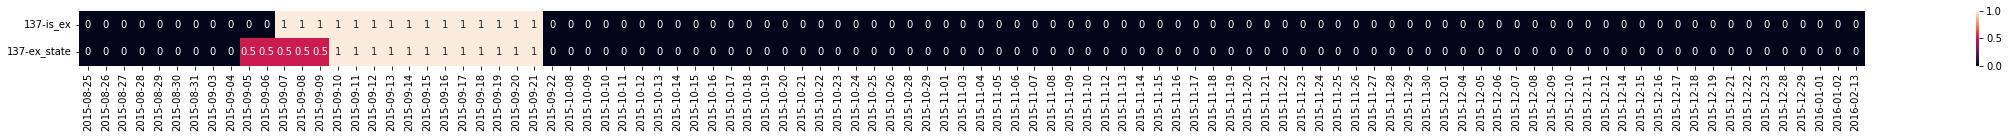

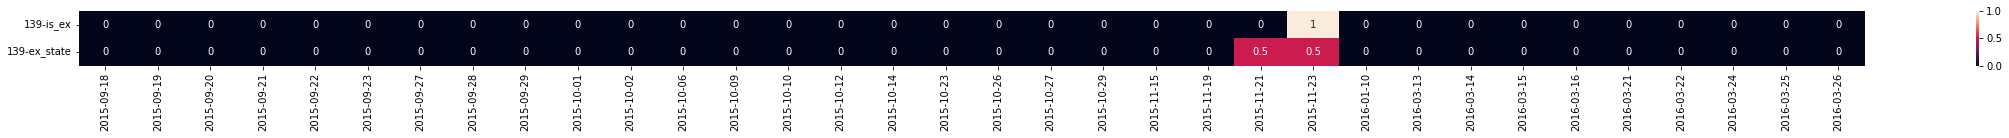

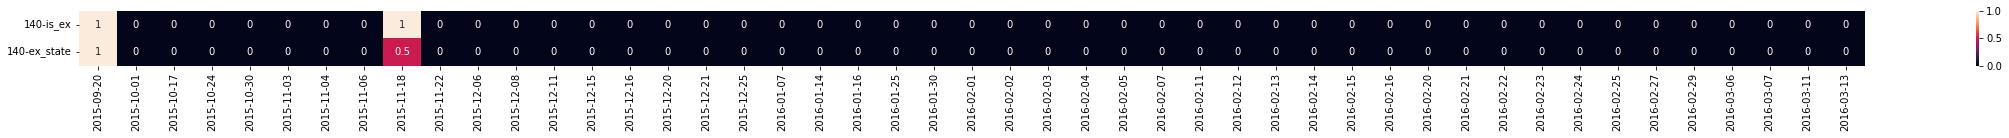

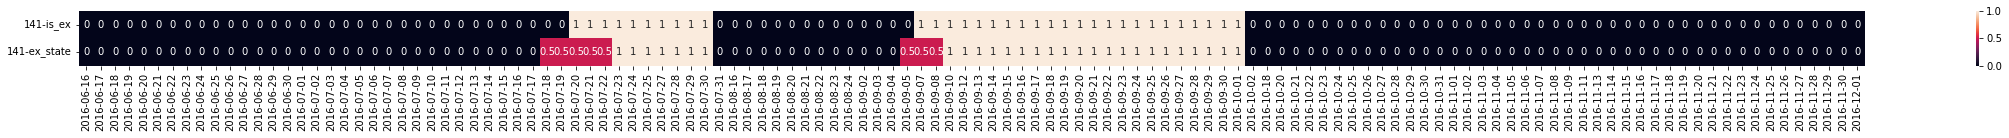

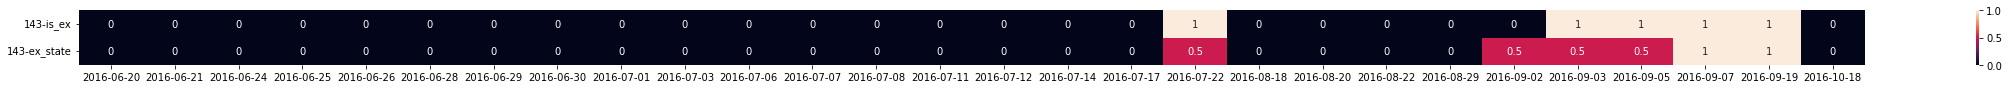

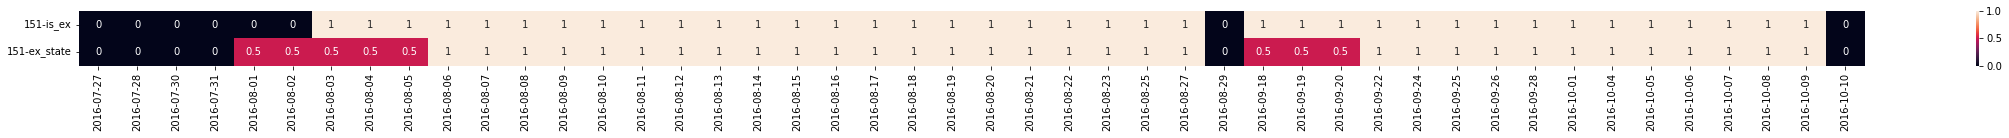

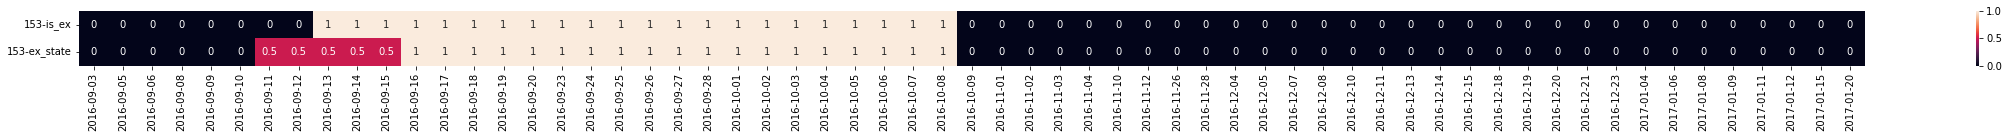

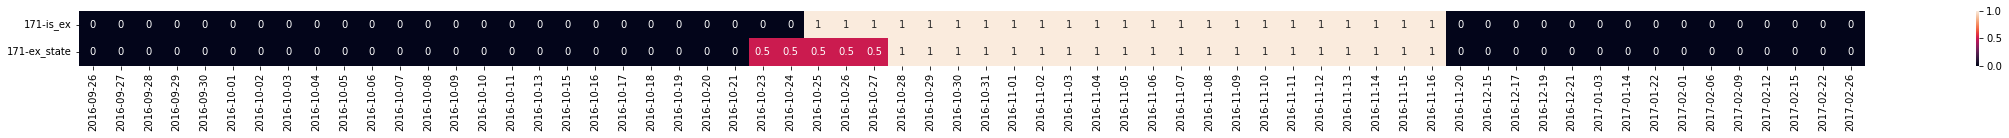

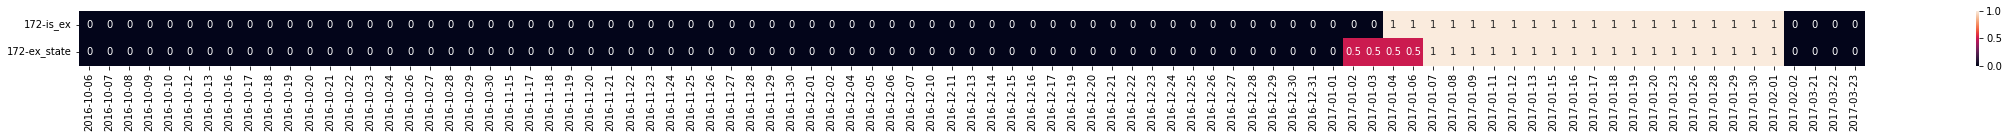

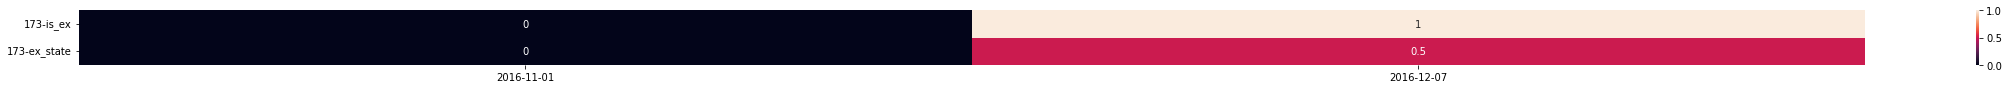

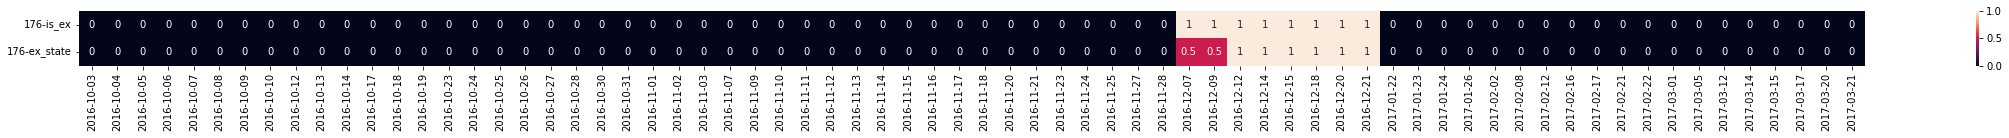

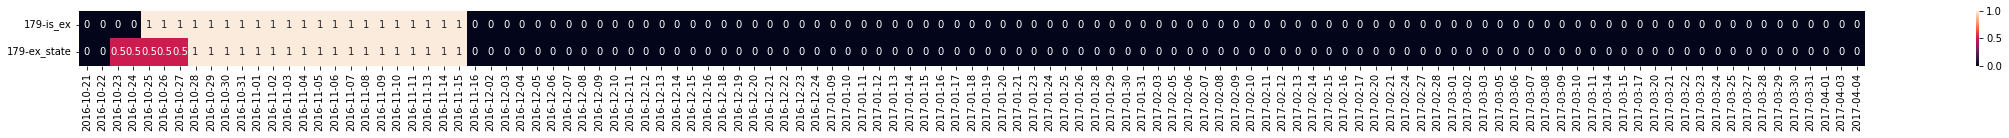

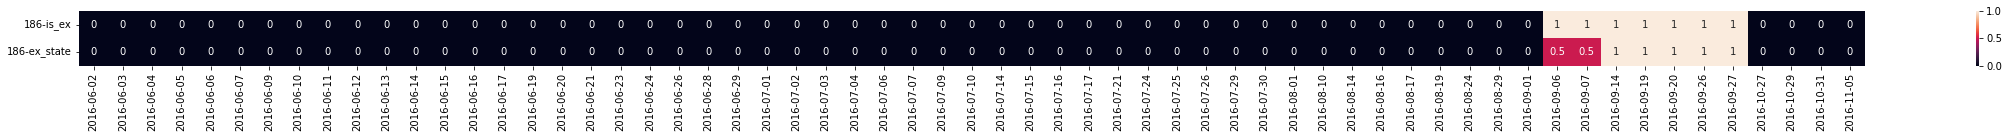

In [3]:
df_transition = ex_labels_data.mark_ex_transition_period(
    O2_FEV1_with_ex_labels, n_days_before=2, n_days_after=2
)

for id in df_transition.ID.unique()[0:20]:
    df_for_ID = df_transition[df_transition.ID == id].copy().reset_index(drop=True)
    df_heatmap = pd.DataFrame(
        np.array(
            [
                df_for_ID["Is Exacerbated"].astype(int),
                df_for_ID["Exacerbation State"].astype(float),
            ]
        ),
        index=[f"{id}-is_ex", f"{id}-ex_state"],
        columns=df_for_ID["Date recorded"].to_numpy(),
    )

    # change fig size
    plt.figure(figsize=(40, 1))
    sns.heatmap(df_heatmap, annot=True)
    plt.show()

In [6]:
df_transition.ID.unique()


array(['100', '113', '115', '123', '130', '132', '133', '137', '139',
       '140', '141', '143', '151', '153', '171', '172', '173', '176',
       '179', '186', '188', '193', '194', '195', '200', '214', '215',
       '229', '23', '231', '232', '233', '24', '241', '29', '30', '31',
       '32', '35', '36', '38', '39', '42', '45', '58', '59', '66', '69',
       '70', '71', '78', '79', '92'], dtype=object)